# M1 Metric Analysis

The tabular results of evaluating the M1 footprint metric for the RGPS survey design and all science cases can be found in the metric_results/ directory.  The goal of this notebook is to explore those results in graphical form. 

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

First we need to load some of the configuration information for the metric simulation for future reference.

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
# Load the survey regions
#all_survey_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'region_data', 'rgps_survey_regions.json'))

In [4]:
# Load definitions of science cases and extract the set of topical categories
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

science_categories = []
for author, info in science_cases.items():
    if info['ready_for_use'] and info['category'] not in science_categories:
        science_categories.append(info['category'])

## Useful functions

In [5]:
def select_results(metric_results, author_list, optic_list, survey_list):
    """
    Function to down-select the table of metric results by the name of the author of a science case, optic and survey design.
    """

    rows = []
    for entry in metric_results:
        if entry['Science_case'] in author_list \
            and entry['Optic'] in optic_list \
                and entry['Survey_strategy'] in survey_list:
            rows.append(entry)
            
    sub_results = Table(rows=rows, names=metric_results.colnames)

    return sub_results

## M1 Survey Footprint metric results 

The M1 metric evaluates the overlap between the survey regions requested by the different science cases and those actually included in each survey design.  Note that if a science case or strategy includes multiple regions per filter, the metric the sums the overlapping HEALpixel area for all regions.  

This metric is relevant to all science cases proposed though for different reasons.  For example, the most obvious comparison to make is between the survey region and the wide-area surveys proposed.  But the time domain fields selected are also of interest.  

Since including all proposals in a single graphic would make a very complex plot, the M1 metric is evaluated for the different science categories.  

In [6]:
# Load M1 metric results
m1_results_file = path.join(getcwd(), '..', 'metric_results', 'M1_survey_footprint_combined_results.txt')
m1_results = Table.read(m1_results_file, format='ascii')
m1_results

Survey_strategy,Optic,Science_case,Science_code,M1_%pix,M1_%priority
str11,str4,str25,str10,float64,float64
wide_area,G150,Ivanov1,SP38,0.0,0.0
deep_spec,G150,Ivanov1,SP38,6.722689075630252,6.722689075630252
time_domain,G150,Ivanov1,SP38,0.0,0.0
wide_area,F106,Minniti,SP16,0.0,0.0
deep_spec,F106,Minniti,SP16,0.7183908045977011,0.7183908045977011
time_domain,F106,Minniti,SP16,0.9626436781609196,0.9626436781609196
wide_area,F158,Minniti,SP16,43.96551724137931,43.96551724137931
deep_spec,F158,Minniti,SP16,0.7183908045977011,0.7183908045977011
time_domain,F158,Minniti,SP16,0.9626436781609196,0.9626436781609196


### Regions of interest included in the RGPS Wide-Area Survey Footprint

We load the M1 results for each category of science, and plot heatmaps of the metric results for all proposals within that category.

In [7]:
def plot_metric_optic_heatmap(sim_config, metric_results, strategy_name,
                              metric_name, metric_label, file_path):
    """
    Function to plot a heatmap of a set of metric results.
    """

    # Downselect the metric results table for the entries corresponding to the requested strategy
    idx = metric_results['Survey_strategy'] == strategy_name
    metric_filter = metric_results[idx]

    # Use only those science cases where metric results were calculated for this filter
    # This excludes science cases that did not request a given filter.
    science_cases = list(set(metric_filter['Science_case'].data))
    science_cases.sort(reverse=True)

    science_codes = []
    science_labels = []
    for case in science_cases:
        idx = np.where(metric_filter['Science_case'] == case)[0]
        science_codes.append(metric_filter['Science_code'][idx[0]])
        science_labels.append(metric_filter['Science_code'][idx[0]] + ' (' + case + ')')
        
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 0.75*len(science_cases)))
    
    data = np.zeros((len(science_cases), len(sim_config['OPTICAL_COMPONENTS'])))

    # Select all metric results for the current filter
    for ioptic, optic in enumerate(sim_config['OPTICAL_COMPONENTS']):
        jdx = np.where(metric_filter['Optic'] == optic)[0]

        for iscience, science_name in enumerate(science_cases):
            kdx = np.where(metric_filter[jdx]['Science_case'] == science_name)[0]

            # Not all science cases request all filters, so it is possible to have no results here
            if len(metric_filter[jdx][kdx]) > 0:
                data[iscience, ioptic] = metric_filter[jdx][kdx][metric_name].data
            else:
                data[iscience, ioptic] = np.nan

    # The plotted grids for a heat map have to account for Python's indexing
    xgrid = np.arange(0, len(sim_config['OPTICAL_COMPONENTS']) + 1, 1)
    ygrid = np.arange(0, len(science_cases) + 1, 1)

    # Plot normalised metric data
    norm = mpl.colors.Normalize(0.0, 100.0)
    ax.pcolormesh(xgrid, ygrid, data, cmap="magma", norm=norm)

    # Label axes
    ax.set_frame_on(False)

    ax.set_xticks(xgrid[0:-1] + 0.5)
    ax.set_yticks(ygrid[0:-1] + 0.5)
    ax.set_ylabel('Science case', fontsize=30)
    ax.set_xlabel('Optic', fontsize=30)
    ax.set_xticklabels(sim_config['OPTICAL_COMPONENTS'], rotation=45.0, horizontalalignment='right', fontsize=30)
    ax.set_yticklabels(science_labels, fontsize=30, horizontalalignment='right')

    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap="magma"),
        ax=ax,  # Pass the new axis
        orientation="vertical")
    cb.set_label(metric_label, fontsize=30)
    cb.ax.tick_params(labelsize=20)

    plt.tight_layout()
    plt.savefig(file_path)
    #plt.close(fig)

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_94925/2388490558.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[iscience, ioptic] = metric_filter[jdx][kdx][metric_name].data


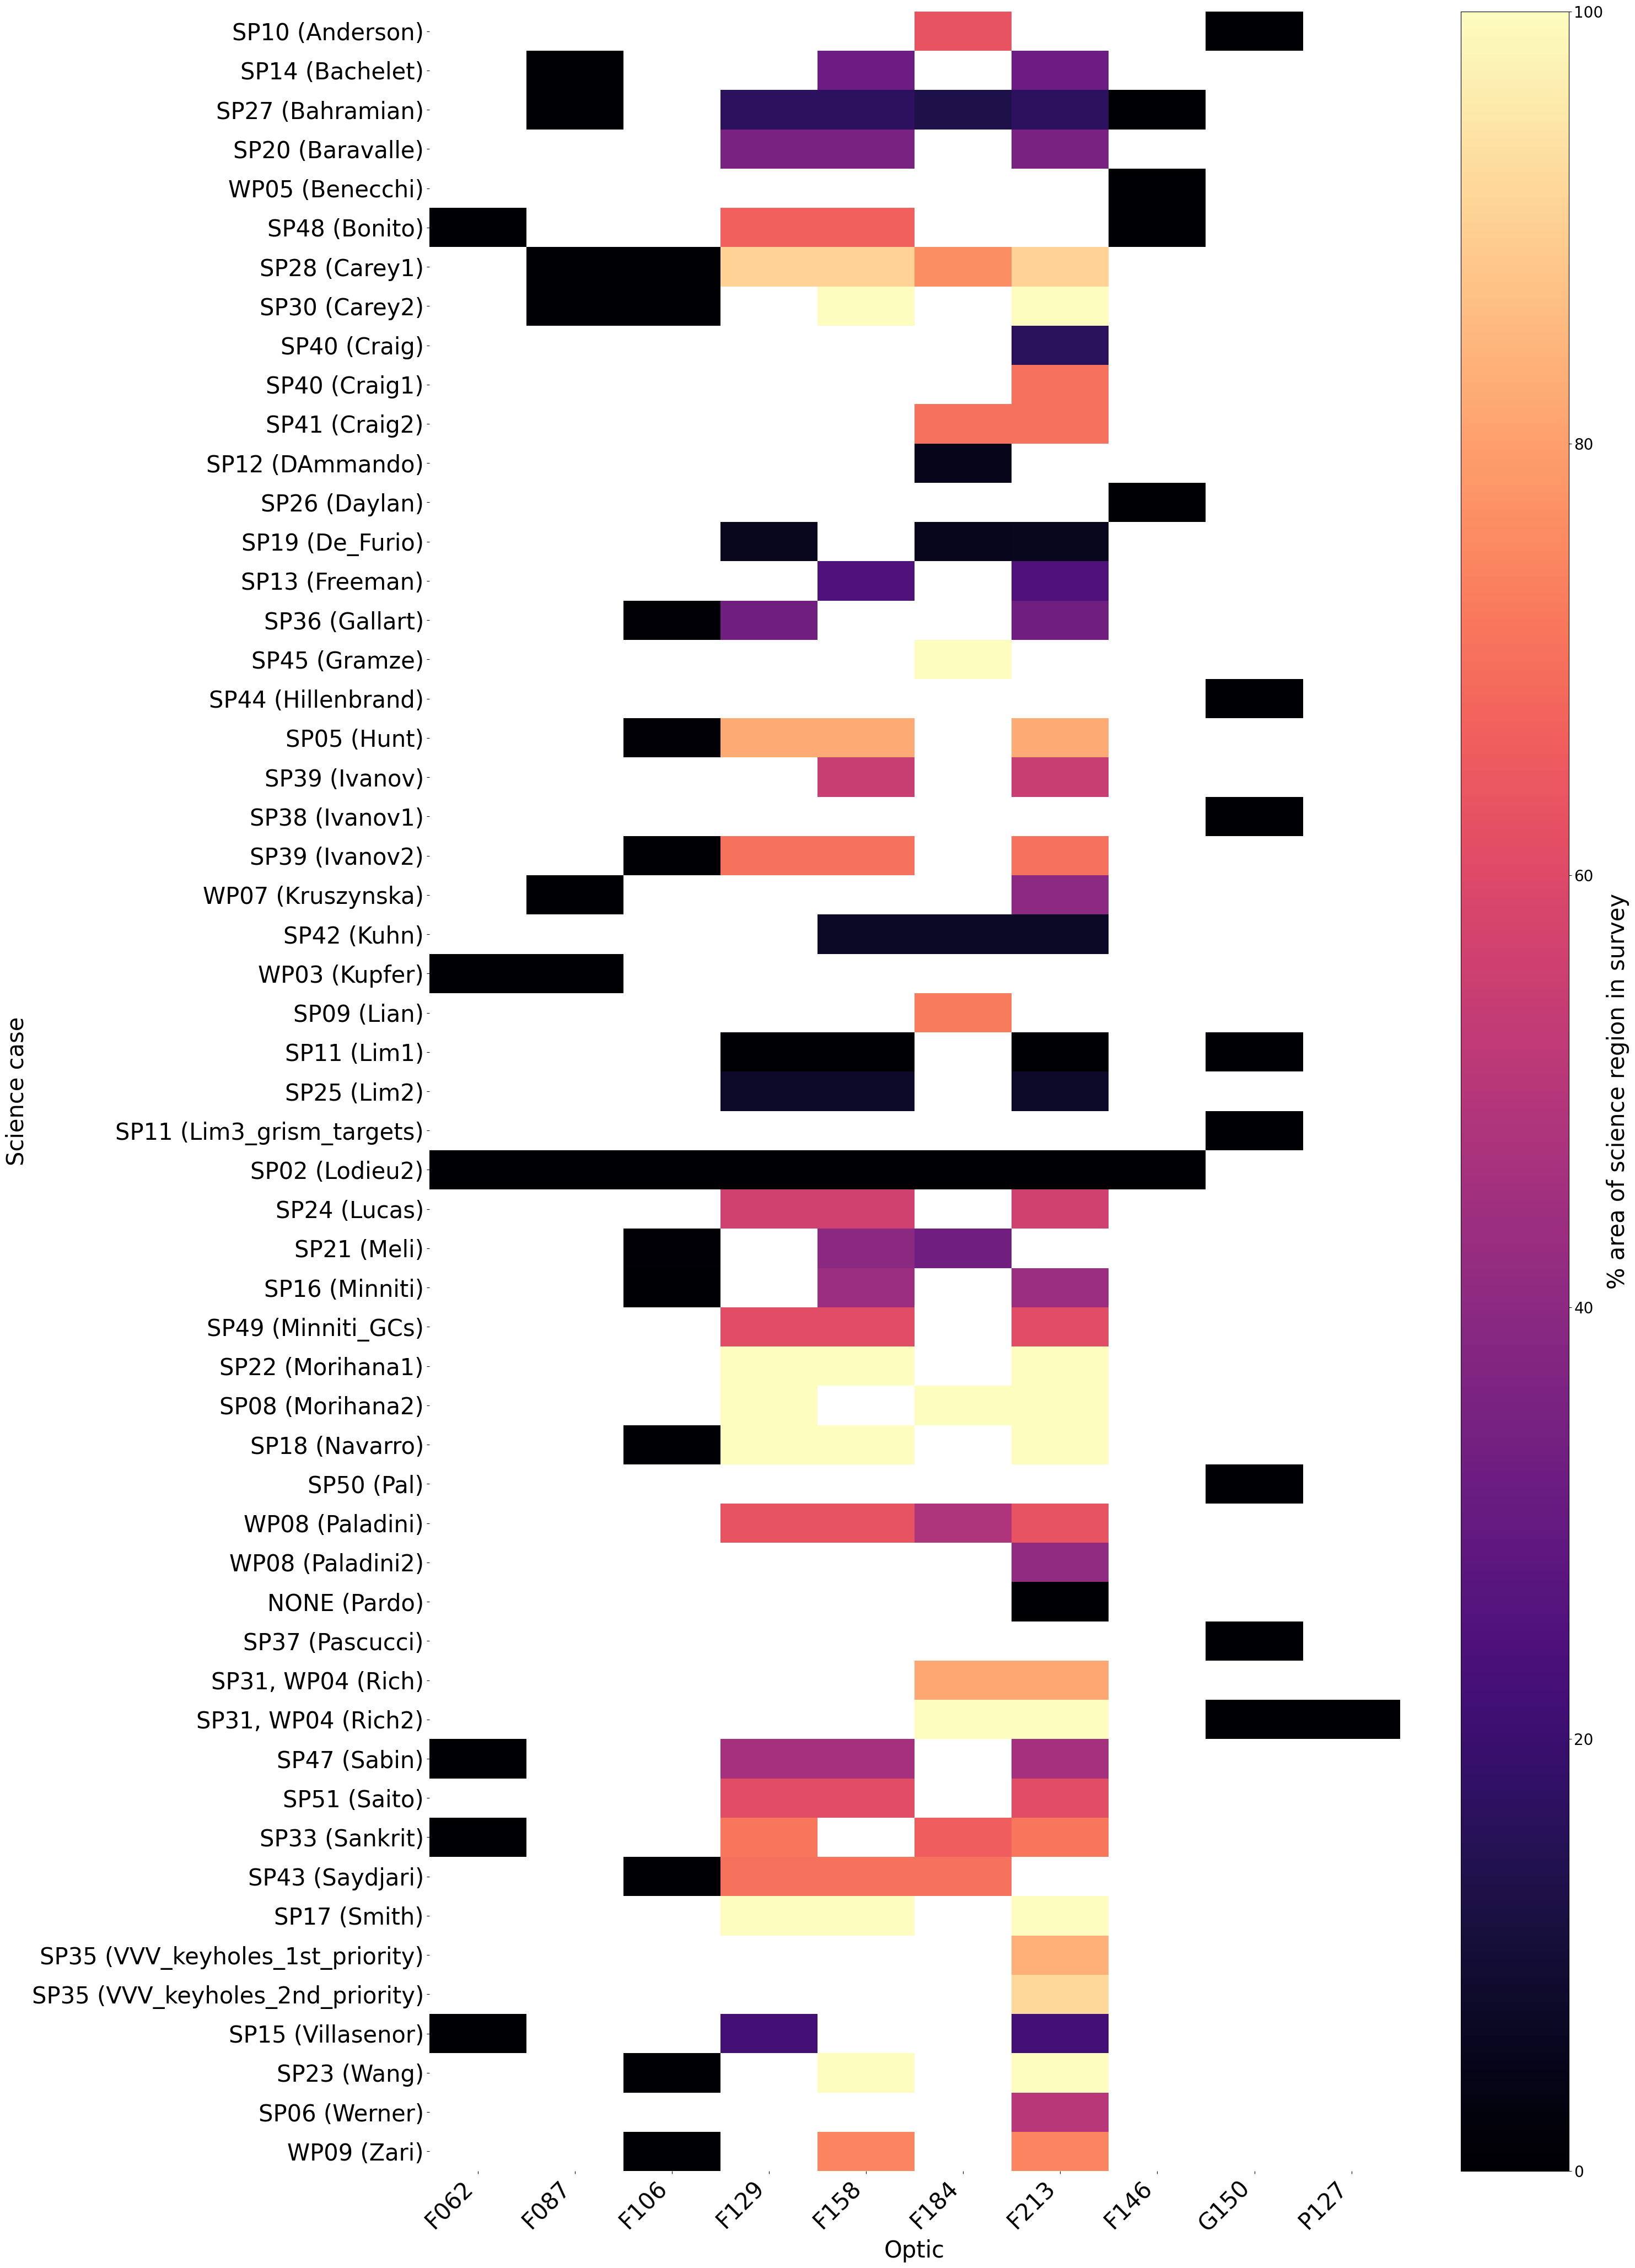

In [8]:
strategy_name = 'wide_area'
metric_name = 'M1_%pix'
metric_label = '% area of science region in survey'

plot_file = path.join(sim_config['root_dir'], 'metric_results', 'm1_results_heatmap_all_science_cases.png')
plot_metric_optic_heatmap(sim_config, m1_results, strategy_name, 
                                  metric_name, metric_label, plot_file) 
    

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_81828/2388490558.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[iscience, ioptic] = metric_filter[jdx][kdx][metric_name].data


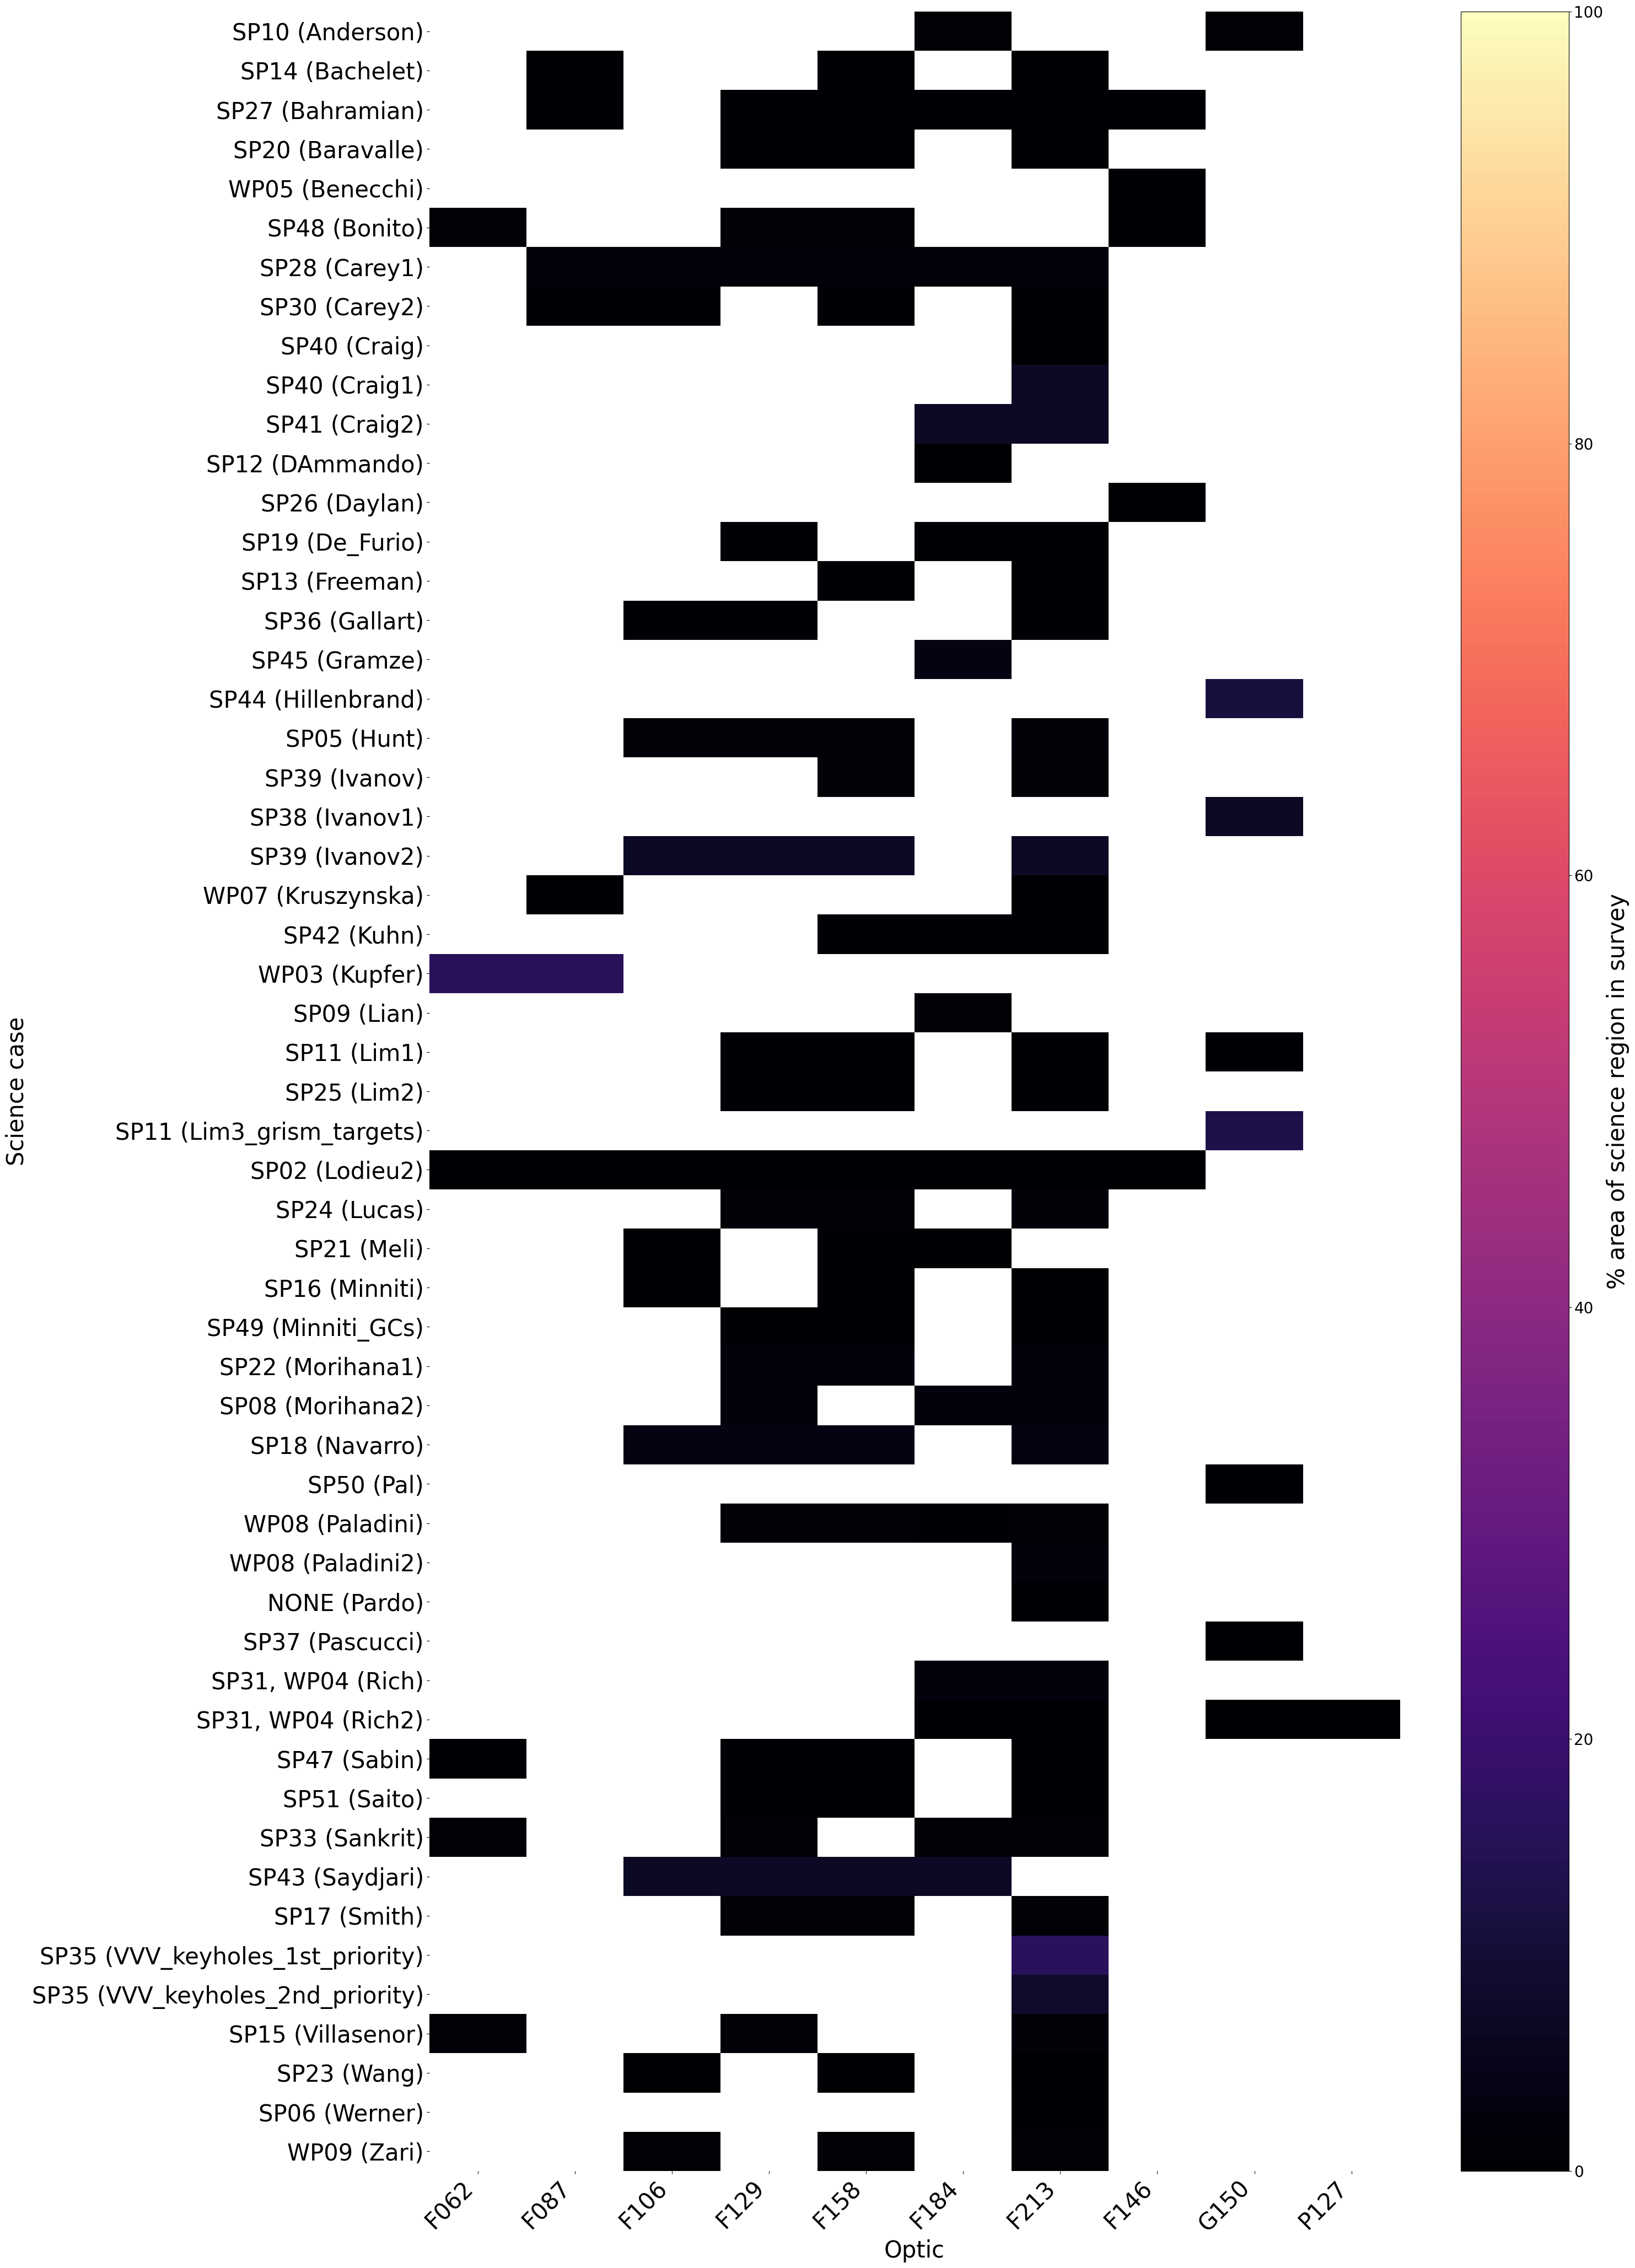

In [27]:
strategy_name = 'deep_spec'
metric_name = 'M1_%pix'
metric_label = '% area of science region in survey'

plot_file = path.join(sim_config['root_dir'], 'metric_results', 'm1_results_heatmap_all_science_cases.png')
plot_metric_optic_heatmap(sim_config, m1_results, strategy_name, 
                                  metric_name, metric_label, plot_file) 
    